# **Financial Stock Analysis Using Agentic AI**

In [1]:
!pip install sec-edgar-downloader pandas tqdm transformers
!pip install yfinance
!pip install pandas matplotlib seaborn textblob wordcloud


**Data Fetching and Loading**

In [10]:
import yfinance as yf
from datetime import datetime, timedelta
import warnings
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
# Suppress all warnings
warnings.filterwarnings("ignore")

# Set the date range
end_date = "2025-04-13"  # End date as April 13, 2025
start_date = "2023-09-20"  # Start date as September 29, 2023

# Download stock data for the S&P 500 index (^GSPC) with all requested columns
stock = yf.download("^GSPC", start=start_date, end=end_date)[["Open", "High", "Low", "Close", "Volume"]]

# Add Date column explicitly
stock.insert(0, "Date", stock.index)

# Reset index and drop the old index
stock.reset_index(drop=True, inplace=True)

# Sort data in descending order (latest date first)
stock = stock.sort_values(by="Date", ascending=False)

# Save data as CSV
stock.to_csv("Stock_data.csv", index=False)  # Save without index

print("Stock data (S&P 500) saved with latest data first, including Open, High, Low, Close, and Volume.")

[*********************100%***********************]  1 of 1 completed

Stock data (S&P 500) saved with latest data first, including Open, High, Low, Close, and Volume.


**Data Preparation and Merging**

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from textblob import TextBlob
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

# Set plot style
sns.set(style="whitegrid")

# Uncomment the line below only if you're running in a Jupyter Notebook
%matplotlib inline


In [3]:
# Load datasets
df1 = pd.read_excel('/content/Final_Edgar_data.xlsx')
df2 = pd.read_csv('/content/Stock_data_final.csv')

# Rename 'Company Name' to 'company' if needed
if 'Company Name' in df1.columns:
    df1 = df1.rename(columns={'Company Name': 'company'})

# Convert dates to datetime
df1['Filing_date'] = pd.to_datetime(df1['Filing_date'], errors='coerce')
df2['Date'] = pd.to_datetime(df2['Date'], errors='coerce')

# Merge on Filing_date = Date
merged_df = pd.merge(df1, df2, how='left', left_on='Filing_date', right_on='Date')
if 'Date' in merged_df.columns:
    merged_df = merged_df.drop(columns=['Date'])

# Reorder columns
desired_columns = ['company', 'Ticker', 'Filing_date', 'filing_type', 'Open', 'High', 'Low', 'Close', 'Volume']
remaining_columns = [col for col in merged_df.columns if col not in desired_columns]
merged_df = merged_df[desired_columns + remaining_columns]

# Sort by Filing_date (latest first)
merged_df = merged_df.sort_values(by='Filing_date', ascending=False)

# Save initial merged data
merged_df.to_excel('/content/Merged_Edgar_Stock_data_Sorted.xlsx', index=False)
print("Merged and sorted data saved to Merged_Edgar_Stock_data_Sorted.xlsx")

Merged and sorted data saved to Merged_Edgar_Stock_data_Sorted.xlsx


In [4]:

# Display the head of the sorted DataFrame
print("Head of the sorted DataFrame:")
merged_df.head()

Head of the sorted DataFrame:


,company,Ticker,Filing_date,filing_type,Open,High,Low,Close,Volume,cik,...,item_8,item_9,item_9A,item_9B,item_10,item_11,item_12,item_13,item_14,item_15
0,Alphabet (Google),GOOGL,2025-04-13,4,NaN,NaN,NaN,NaN,NaN,1721947,...,Item 8. Financial Statements and Supplementary...,Item 9. Changes in and Disagreements with Acco...,Item 9A. Controls and Procedures\nEvaluation o...,Item 9B. Other Information\nNot applicable.\nP...,"Item 10. Directors, Executive Officers and Cor...",Item 11. Executive Compensation\nThe informati...,Item 12. Security Ownership of Certain Benefic...,Item 13. Certain Relationships and Related Par...,Item 14. Principal Accountant Fees and Service...,Item 15. Exhibits and Financial Statement Sche...
1,Alphabet (Google),GOOGL,2025-04-12,4,NaN,NaN,NaN,NaN,NaN,1477333,...,Item 8. Financial Statements and Supplementary...,Item 9. Changes in and Disagreements with Acco...,Item 9A. Controls and Procedures\nEvaluation o...,Item 9B. Other Information\nNone.\nPART III,"Item 10. Directors, Executive Officers and Cor...",Item 11. Executive Compensation\nThe informati...,Item 12. Security Ownership of Certain Benefic...,Item 13. Certain Relationships and Related Tra...,Item 14. Principal Accounting Fees and Service...,Item 15. Exhibits and Financial Statement Sche...
2,Alphabet (Google),GOOGL,2025-04-11,4,5255.560059,5381.459961,5220.770020,5363.359863,5.602550e+09,827876,...,Item 8. Financial Statements and Supplementary...,Item 9. Changes in and Disagreements With Acco...,Item 9A. Controls and Procedures\nEVALUATION O...,Item 9B. Other Information\nNone.\nPART III,"Item 10 - Directors, Executive Officers, and C...",Item 11 - Executive Compensation\nThe informat...,Item 12 - Security Ownership of Certain Benefi...,Item 13 - Certain Relationships and Related Tr...,Item 14 - Principal Accounting Fees and Servic...,Item 15. Exhibits and Financial Statement Sche...
3,Meta (Facebook),META,2025-04-10,4,5353.149902,5353.149902,5115.270020,5268.049805,6.677140e+09,1627857,...,Item 8. Financial Statements and Supplementary...,Item 9. Changes in and Disagreements with Acco...,Item 9A. Controls and Procedures\nEvaluation o...,Item 9B. Other Information\nNone\nPART III,"Item 10. Directors, Executive Officers and Cor...",Item 11. Executive Compensation\nThe informati...,Item 12. Security Ownership of Certain Benefic...,Item 13. Certain Relationships and Related Tra...,Item 14. Principal Accountant Fees and Service...,Item 15. Exhibits and Financial Statement Sche...
4,Berkshire Hathaway,BRK-B,2025-04-09,4,4965.279785,5481.339844,4948.430176,5456.899902,9.489600e+09,1108524,...,ITEM 8. FINANCIAL STATEMENTS\nINDEX TO CONSOLI...,ITEM 9. CHANGES IN AND DISAGREEMENTS WITH ACCO...,ITEM 9A. CONTROLS AND PROCEDURES\n(a) Evaluati...,ITEM 9B. OTHER INFORMATION\nNot applicable.\nP...,"ITEM 10. DIRECTORS, EXECUTIVE OFFICERS AND COR...",ITEM 11. EXECUTIVE COMPENSATION\nThe informati...,ITEM 12. SECURITY OWNERSHIP OF CERTAIN BENEFIC...,ITEM 13. CERTAIN RELATIONSHIPS AND RELATED TRA...,ITEM 14. PRINCIPAL ACCOUNTANT FEES AND SERVICE...,ITEM 15. EXHIBITS AND FINANCIAL STATEMENT SCHE...


In [5]:

# Display the info of the sorted DataFrame
print("\nInfo of the sorted DataFrame:")
merged_df.info()


Info of the sorted DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 382 entries, 0 to 381
Data columns (total 38 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   company                    382 non-null    object        
 1   Ticker                     381 non-null    object        
 2   Filing_date                382 non-null    datetime64[ns]
 3   filing_type                382 non-null    object        
 4   Open                       232 non-null    float64       
 5   High                       232 non-null    float64       
 6   Low                        232 non-null    float64       
 7   Close                      232 non-null    float64       
 8   Volume                     232 non-null    float64       
 9   cik                        382 non-null    int64         
 10  sic                        382 non-null    int64         
 11  state_of_inc               342 non-null    ob

## **Handling Missing Stock Data**

In [6]:
# Flag rows with stock data
merged_df['has_stock_data'] = ~merged_df['Open'].isnull()

# Summarize missingness
print("Stock Data Availability:")
print(merged_df['has_stock_data'].value_counts())
print("\nStock Data by Filing Type:")
print(merged_df.groupby('filing_type')['has_stock_data'].mean())
print("\nStock Data by Company (Top 10):")
print(merged_df.groupby('company')['has_stock_data'].mean().sort_values(ascending=False).head(10))


Stock Data Availability:
has_stock_data
True     232
False    150
Name: count, dtype: int64

Stock Data by Filing Type:
filing_type
4       0.670659
10-K    0.536458
10-Q    0.666667
8-K     0.764706
Name: has_stock_data, dtype: float64

Stock Data by Company (Top 10):
company
2U, Inc.                         1.0
8X8 INC /DE/                     1.0
A10 Networks, Inc.               1.0
ACI WORLDWIDE, INC.              1.0
AGILYSYS INC                     1.0
APPFOLIO INC                     1.0
ANSYS INC                        1.0
BOTTOMLINE TECHNOLOGIES INC      1.0
DATTO HOLDING CORP.              1.0
AUTOMATIC DATA PROCESSING INC    1.0
Name: has_stock_data, dtype: float64


In [7]:
# Flag rows with stock data
merged_df['has_stock_data'] = ~merged_df['Open'].isnull()

# Summarize stock data availability
print("Stock Data Availability:")
print(merged_df['has_stock_data'].value_counts())
print("\nStock Data by Filing Type:")
print(merged_df.groupby('filing_type')['has_stock_data'].mean())

# Impute using nearest trading day
stock_ref = merged_df[merged_df['has_stock_data']][['Filing_date', 'Open', 'High', 'Low', 'Close', 'Volume']].copy()
stock_ref = stock_ref.sort_values('Filing_date')

def impute_nearest(row, stock_ref, max_days=5):
    if pd.notnull(row['Open']):
        return row
    date_diff = (stock_ref['Filing_date'] - row['Filing_date']).abs()
    valid_diffs = date_diff[date_diff.dt.days <= max_days]
    if valid_diffs.empty:
        return row
    nearest_idx = valid_diffs.idxmin()
    row[['Open', 'High', 'Low', 'Close', 'Volume']] = stock_ref.loc[nearest_idx, ['Open', 'High', 'Low', 'Close', 'Volume']]
    return row

# Create imputed dataset
imputed_df = merged_df.copy()
imputed_df = imputed_df.apply(lambda row: impute_nearest(row, stock_ref), axis=1)

# Compare missing values
print("\nMissing Values Before Imputation:")
print(merged_df[['Open', 'High', 'Low', 'Close', 'Volume']].isnull().sum())
print("\nMissing Values After Imputation:")
print(imputed_df[['Open', 'High', 'Low', 'Close', 'Volume']].isnull().sum())

Stock Data Availability:
has_stock_data
True     232
False    150
Name: count, dtype: int64

Stock Data by Filing Type:
filing_type
4       0.670659
10-K    0.536458
10-Q    0.666667
8-K     0.764706
Name: has_stock_data, dtype: float64

Missing Values Before Imputation:
Open      150
High      150
Low       150
Close     150
Volume    150
dtype: int64

Missing Values After Imputation:
Open      7
High      7
Low       7
Close     7
Volume    7
dtype: int64


## **Data Overview**

In [8]:
print("\nImputed Dataset Info:")
imputed_df.info()


Imputed Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 382 entries, 0 to 381
Data columns (total 39 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   company                    382 non-null    object        
 1   Ticker                     381 non-null    object        
 2   Filing_date                382 non-null    datetime64[ns]
 3   filing_type                382 non-null    object        
 4   Open                       375 non-null    float64       
 5   High                       375 non-null    float64       
 6   Low                        375 non-null    float64       
 7   Close                      375 non-null    float64       
 8   Volume                     375 non-null    float64       
 9   cik                        382 non-null    int64         
 10  sic                        382 non-null    int64         
 11  state_of_inc               342 non-null    object    

In [9]:
# Head of imputed dataset
print("\nFirst 5 Rows (Imputed):")
display(imputed_df.head())



First 5 Rows (Imputed):


,company,Ticker,Filing_date,filing_type,Open,High,Low,Close,Volume,cik,...,item_9,item_9A,item_9B,item_10,item_11,item_12,item_13,item_14,item_15,has_stock_data
0,Alphabet (Google),GOOGL,2025-04-13,4,5255.560059,5381.459961,5220.770020,5363.359863,5.602550e+09,1721947,...,Item 9. Changes in and Disagreements with Acco...,Item 9A. Controls and Procedures\nEvaluation o...,Item 9B. Other Information\nNot applicable.\nP...,"Item 10. Directors, Executive Officers and Cor...",Item 11. Executive Compensation\nThe informati...,Item 12. Security Ownership of Certain Benefic...,Item 13. Certain Relationships and Related Par...,Item 14. Principal Accountant Fees and Service...,Item 15. Exhibits and Financial Statement Sche...,False
1,Alphabet (Google),GOOGL,2025-04-12,4,5255.560059,5381.459961,5220.770020,5363.359863,5.602550e+09,1477333,...,Item 9. Changes in and Disagreements with Acco...,Item 9A. Controls and Procedures\nEvaluation o...,Item 9B. Other Information\nNone.\nPART III,"Item 10. Directors, Executive Officers and Cor...",Item 11. Executive Compensation\nThe informati...,Item 12. Security Ownership of Certain Benefic...,Item 13. Certain Relationships and Related Tra...,Item 14. Principal Accounting Fees and Service...,Item 15. Exhibits and Financial Statement Sche...,False
2,Alphabet (Google),GOOGL,2025-04-11,4,5255.560059,5381.459961,5220.770020,5363.359863,5.602550e+09,827876,...,Item 9. Changes in and Disagreements With Acco...,Item 9A. Controls and Procedures\nEVALUATION O...,Item 9B. Other Information\nNone.\nPART III,"Item 10 - Directors, Executive Officers, and C...",Item 11 - Executive Compensation\nThe informat...,Item 12 - Security Ownership of Certain Benefi...,Item 13 - Certain Relationships and Related Tr...,Item 14 - Principal Accounting Fees and Servic...,Item 15. Exhibits and Financial Statement Sche...,True
3,Meta (Facebook),META,2025-04-10,4,5353.149902,5353.149902,5115.270020,5268.049805,6.677140e+09,1627857,...,Item 9. Changes in and Disagreements with Acco...,Item 9A. Controls and Procedures\nEvaluation o...,Item 9B. Other Information\nNone\nPART III,"Item 10. Directors, Executive Officers and Cor...",Item 11. Executive Compensation\nThe informati...,Item 12. Security Ownership of Certain Benefic...,Item 13. Certain Relationships and Related Tra...,Item 14. Principal Accountant Fees and Service...,Item 15. Exhibits and Financial Statement Sche...,True
4,Berkshire Hathaway,BRK-B,2025-04-09,4,4965.279785,5481.339844,4948.430176,5456.899902,9.489600e+09,1108524,...,ITEM 9. CHANGES IN AND DISAGREEMENTS WITH ACCO...,ITEM 9A. CONTROLS AND PROCEDURES\n(a) Evaluati...,ITEM 9B. OTHER INFORMATION\nNot applicable.\nP...,"ITEM 10. DIRECTORS, EXECUTIVE OFFICERS AND COR...",ITEM 11. EXECUTIVE COMPENSATION\nThe informati...,ITEM 12. SECURITY OWNERSHIP OF CERTAIN BENEFIC...,ITEM 13. CERTAIN RELATIONSHIPS AND RELATED TRA...,ITEM 14. PRINCIPAL ACCOUNTANT FEES AND SERVICE...,ITEM 15. EXHIBITS AND FINANCIAL STATEMENT SCHE...,True


## **Numerical Analysis**

In [10]:
# Numerical columns
numerical_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'cik', 'sic', 'fiscal_year_end']

# Summary statistics
print("Numerical Summary (Imputed):")
display(imputed_df[numerical_cols].describe())


Numerical Summary (Imputed):


,Open,High,Low,Close,Volume,cik,sic,fiscal_year_end
count,375.000000,375.000000,375.000000,375.000000,3.750000e+02,3.820000e+02,382.000000,380.000000
mean,5190.133910,5216.928862,5160.856651,5189.725141,4.287610e+09,1.261605e+06,6965.837696,920.400000
std,543.780065,546.580676,538.451414,543.546930,1.151490e+09,3.559931e+05,1235.829227,430.554331
min,4139.390137,4156.700195,4103.779785,4117.370117,1.639500e+09,8.670000e+03,1311.000000,102.000000
25%,4784.659912,4790.864991,4774.939941,4782.465088,3.683930e+09,1.020112e+06,7372.000000,630.000000
50%,5139.089844,5175.600098,5104.350098,5137.080078,3.950210e+09,1.348036e+06,7372.000000,1231.000000
75%,5627.784912,5662.099853,5573.494873,5636.014892,4.599460e+09,1.555434e+06,7372.000000,1231.000000
max,6134.500000,6147.430176,6111.149902,6144.149902,9.489600e+09,1.810806e+06,8700.000000,1231.000000


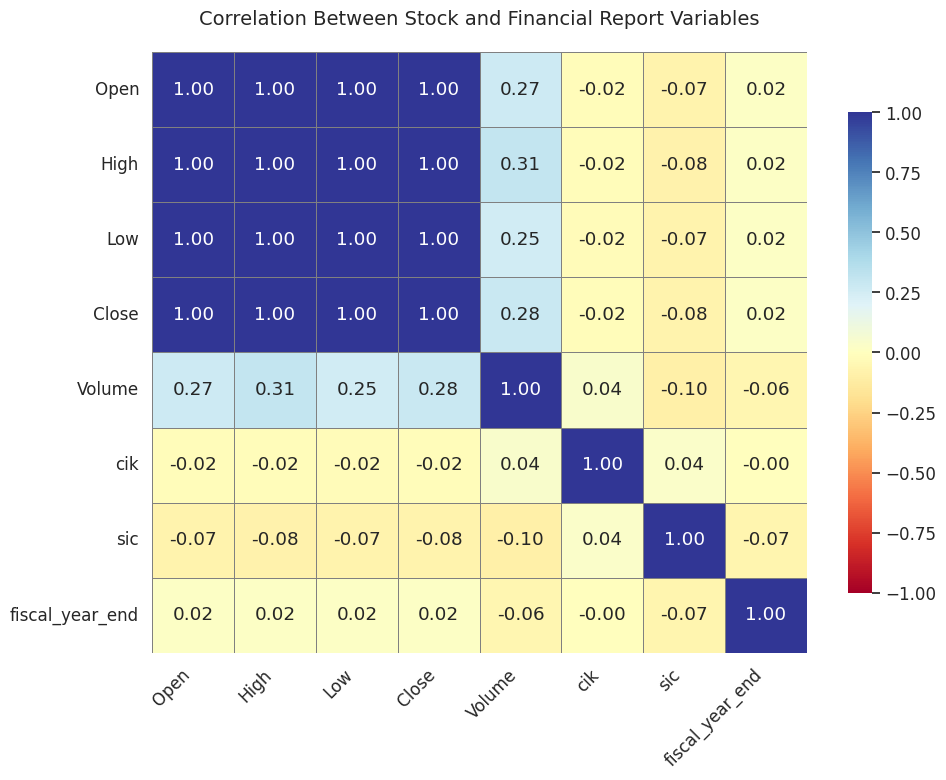

In [11]:
corr_matrix = imputed_df[numerical_cols].corr()

# Set visual style
sns.set(style="whitegrid", font_scale=1.1)

# Create heatmap
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='RdYlBu',  # alternative: 'coolwarm', 'Spectral', 'YlGnBu'
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={"shrink": 0.8}
)

# Improve layout and titles
plt.title('Correlation Between Stock and Financial Report Variables', fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


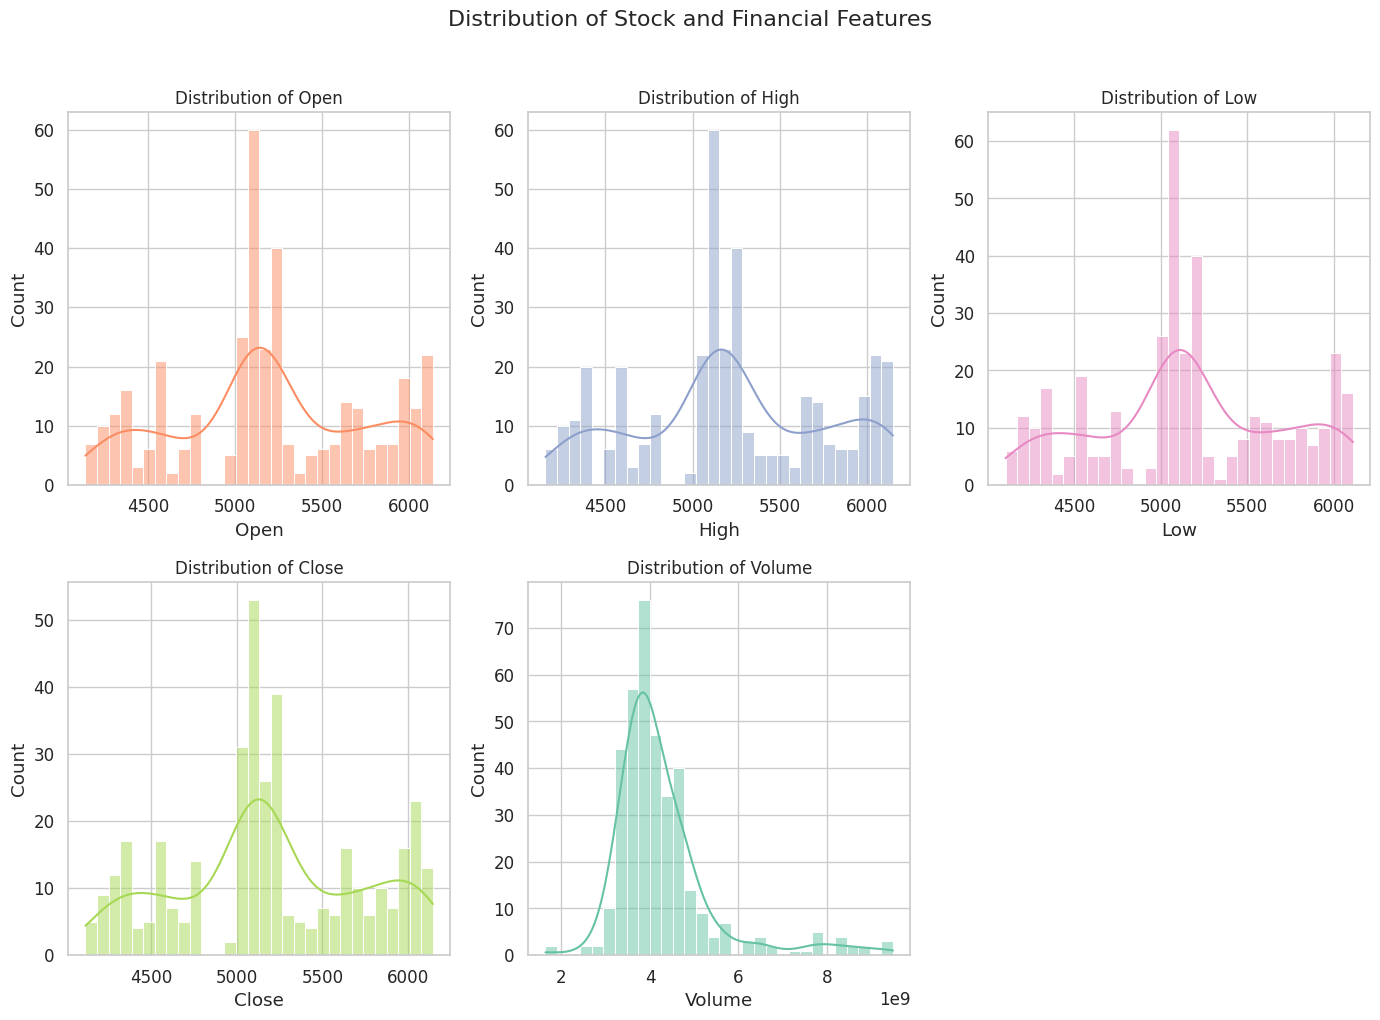

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# Numerical columns
numerical_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

# Distribution plots for numerical features
plt.figure(figsize=(14, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(
        imputed_df[col].dropna(),
        bins=30,
        kde=True,
        color=sns.color_palette("Set2")[i % len(numerical_cols)]
    )
    plt.title(f'Distribution of {col}', fontsize=12)
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.grid(True)

plt.suptitle('Distribution of Stock and Financial Features', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


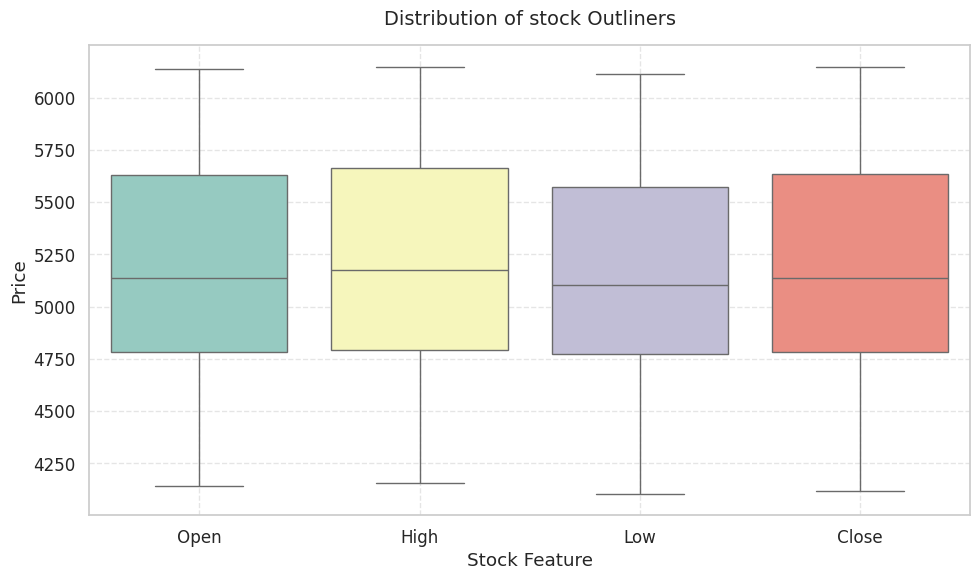

In [41]:

# Boxplot for stock prices
plt.figure(figsize=(10, 6))
stock_cols = ['Open', 'High', 'Low', 'Close']
stock_melted = imputed_df[stock_cols].melt(var_name='Stock Feature', value_name='Price')

sns.boxplot(
    x='Stock Feature',
    y='Price',
    data=stock_melted,
    palette='Set3'
)

plt.title('Distribution of stock Outliners', fontsize=14, pad=15)
plt.xlabel('Stock Feature')
plt.ylabel('Price')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## **Categorical Analysis**

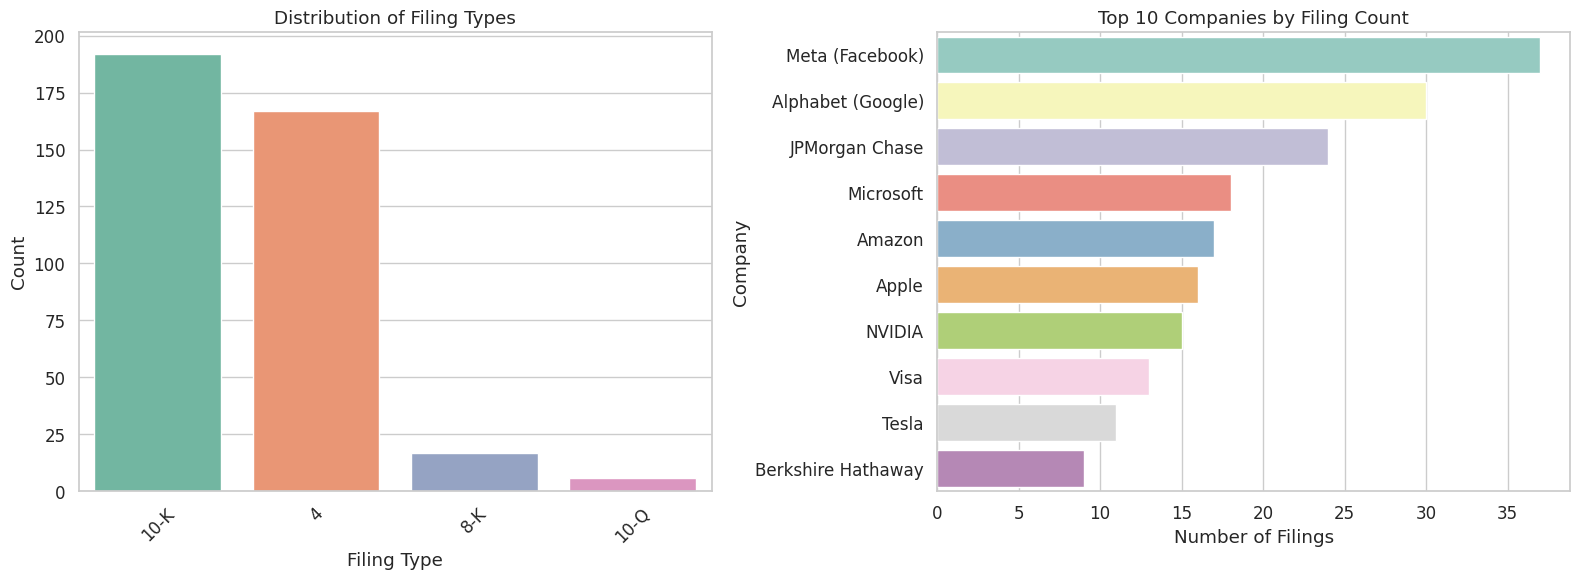

In [14]:
# Set seaborn style
sns.set(style="whitegrid", palette="pastel", font_scale=1.1)

# Subplots side by side: Filing Type Distribution and Top Companies
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Filing type distribution
sns.countplot(
    data=merged_df,
    x='filing_type',
    order=merged_df['filing_type'].value_counts().index,
    ax=axes[0],
    palette='Set2'
)
axes[0].set_title('Distribution of Filing Types')
axes[0].set_xlabel('Filing Type')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Top companies by filing count
top_companies = merged_df['company'].value_counts().head(10)
sns.barplot(
    x=top_companies.values,
    y=top_companies.index,
    ax=axes[1],
    palette='Set3'
)
axes[1].set_title('Top 10 Companies by Filing Count')
axes[1].set_xlabel('Number of Filings')
axes[1].set_ylabel('Company')

plt.tight_layout()
plt.show()




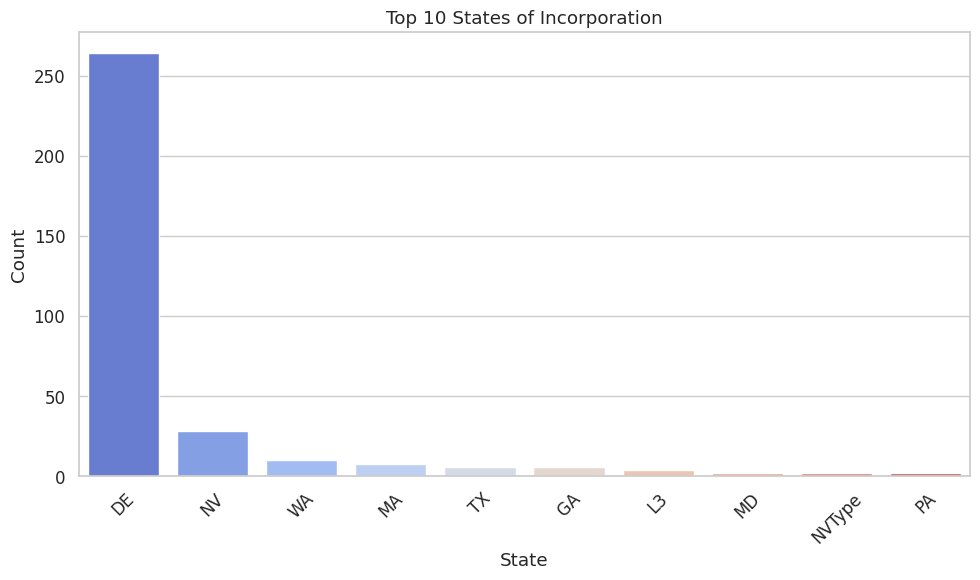

In [15]:
# Third figure: Top States of Incorporation
plt.figure(figsize=(10, 6))
sns.countplot(
    data=merged_df,
    x='state_of_inc',
    order=merged_df['state_of_inc'].value_counts().index[:10],
    palette='coolwarm'
)
plt.title('Top 10 States of Incorporation')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## **Temporal Trends**

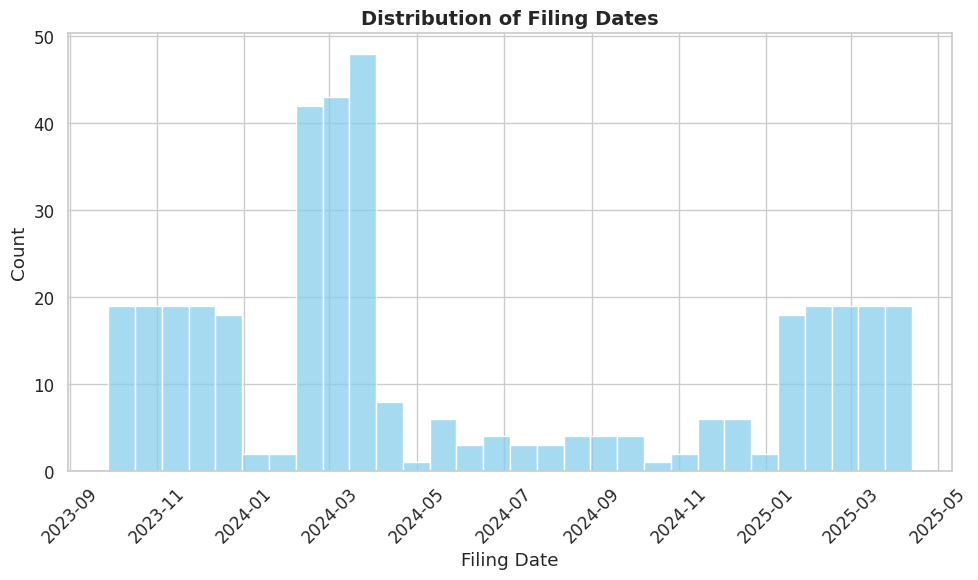

In [16]:

# Set seaborn style
sns.set(style="whitegrid", font_scale=1.1)

# Filing date distribution
plt.figure(figsize=(10, 6))
sns.histplot(imputed_df['Filing_date'], bins=30, color='skyblue')
plt.title('Distribution of Filing Dates', fontsize=14, fontweight='bold')
plt.xlabel('Filing Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




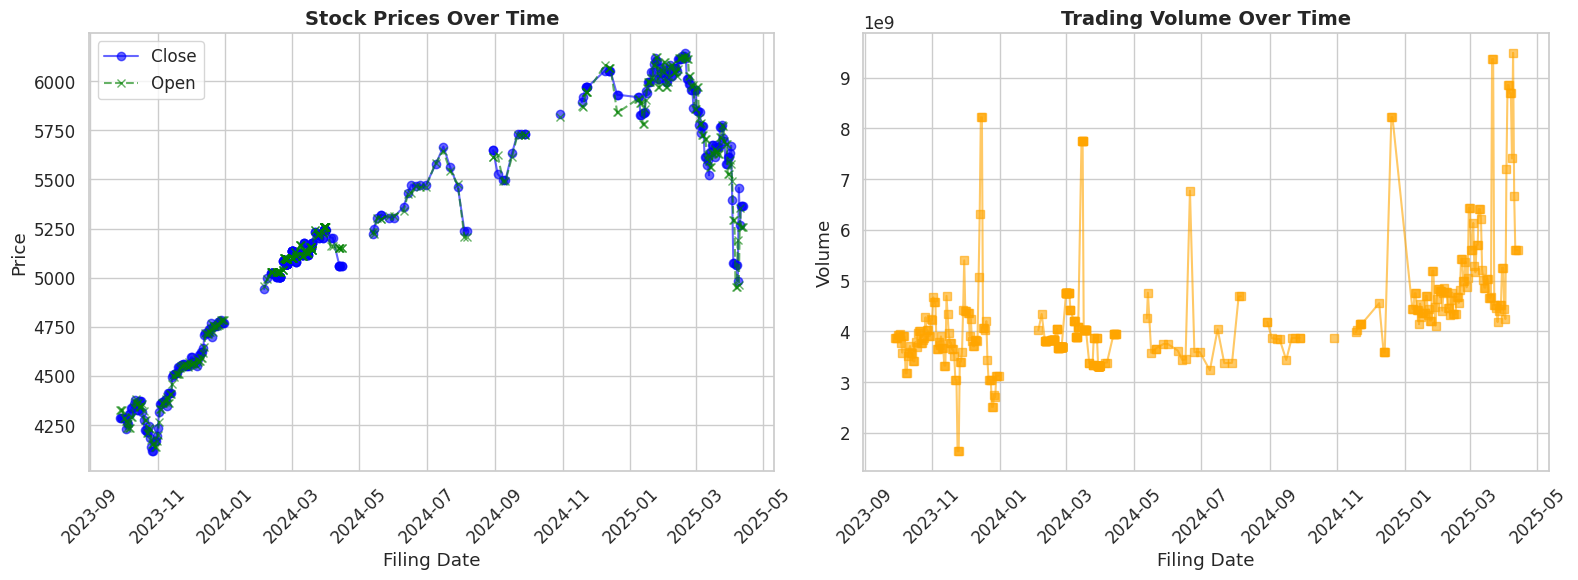

In [17]:
# Side-by-side plots: Stock price trend and Volume trend
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

# Stock price trend
axes[0].plot(imputed_df['Filing_date'], imputed_df['Close'], 'o-', label='Close', alpha=0.6, color='blue')
axes[0].plot(imputed_df['Filing_date'], imputed_df['Open'], 'x--', label='Open', alpha=0.6, color='green')
axes[0].set_title('Stock Prices Over Time', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Filing Date')
axes[0].set_ylabel('Price')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)

# Volume trend
axes[1].plot(imputed_df['Filing_date'], imputed_df['Volume'], 's-', alpha=0.6, color='orange')
axes[1].set_title('Trading Volume Over Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Filing Date')
axes[1].set_ylabel('Volume')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## **Stock-Filings Relationships**

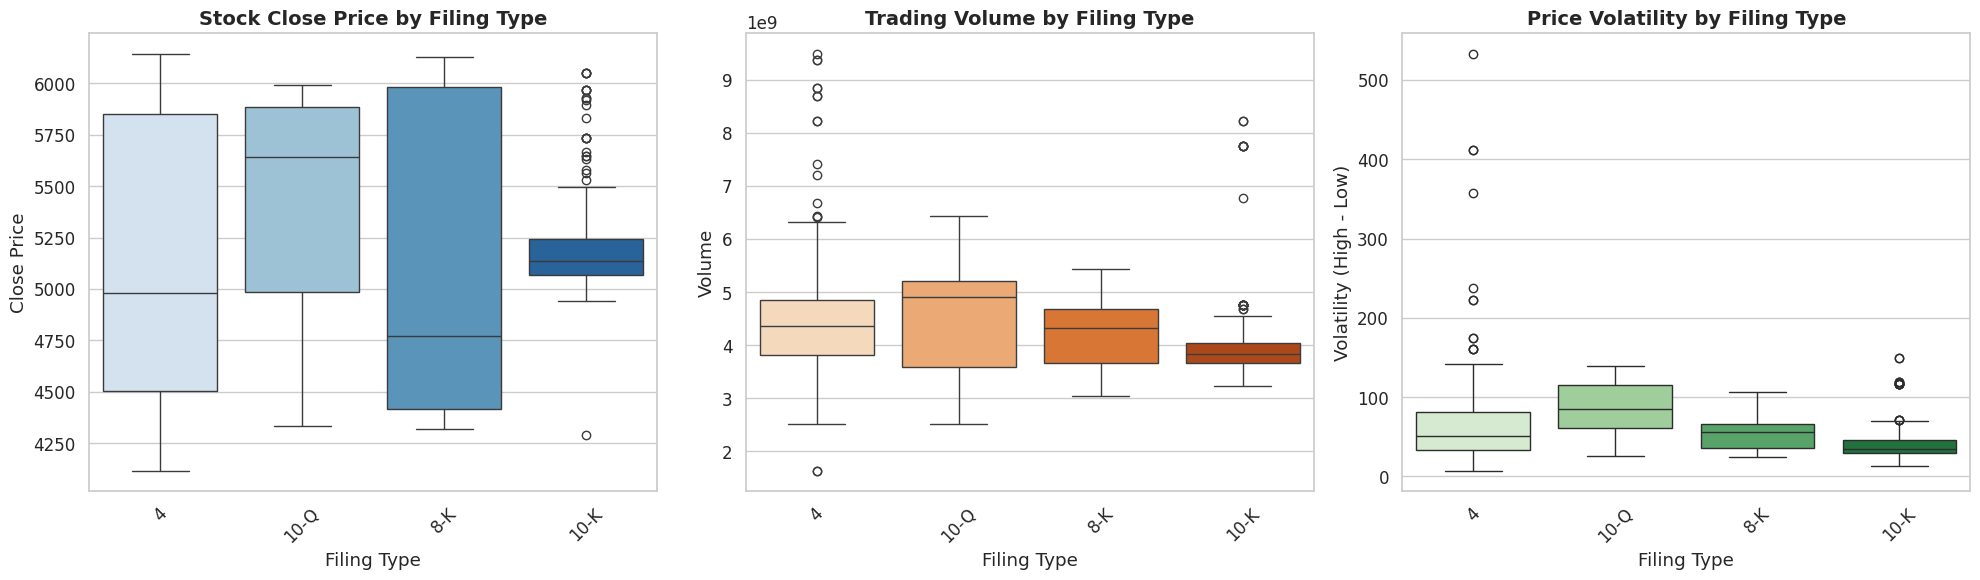

In [18]:

# Calculate volatility
imputed_df['volatility'] = imputed_df['High'] - imputed_df['Low']

# Create one figure with 3 subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=False)

# Stock Close Price by Filing Type
sns.boxplot(data=imputed_df, x='filing_type', y='Close', ax=axes[0], palette='Blues')
axes[0].set_title('Stock Close Price by Filing Type', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Filing Type')
axes[0].set_ylabel('Close Price')
axes[0].tick_params(axis='x', rotation=45)

# Trading Volume by Filing Type
sns.boxplot(data=imputed_df, x='filing_type', y='Volume', ax=axes[1], palette='Oranges')
axes[1].set_title('Trading Volume by Filing Type', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Filing Type')
axes[1].set_ylabel('Volume')
axes[1].tick_params(axis='x', rotation=45)

# Volatility by Filing Type
sns.boxplot(data=imputed_df, x='filing_type', y='volatility', ax=axes[2], palette='Greens')
axes[2].set_title('Price Volatility by Filing Type', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Filing Type')
axes[2].set_ylabel('Volatility (High - Low)')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## **NLP Analysis**

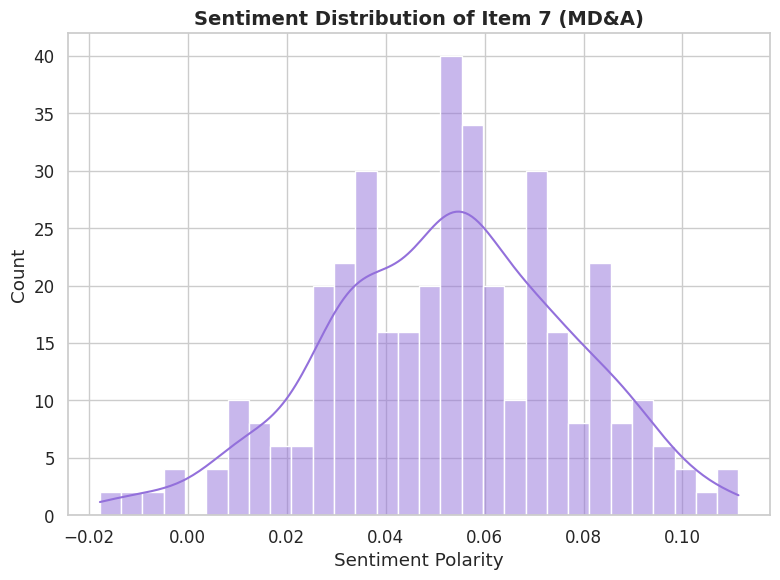

In [19]:
# Compute sentiment for item_7
def get_sentiment(text):
    if pd.isna(text):
        return 0
    return TextBlob(str(text)).sentiment.polarity

imputed_df['item_7_sentiment'] = imputed_df['item_7'].apply(get_sentiment)

# Sentiment distribution
plt.figure(figsize=(8, 6))
sns.histplot(imputed_df['item_7_sentiment'], bins=30, kde=True, color='mediumpurple')
plt.title('Sentiment Distribution of Item 7 (MD&A)', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Count')
plt.tight_layout()
plt.show()




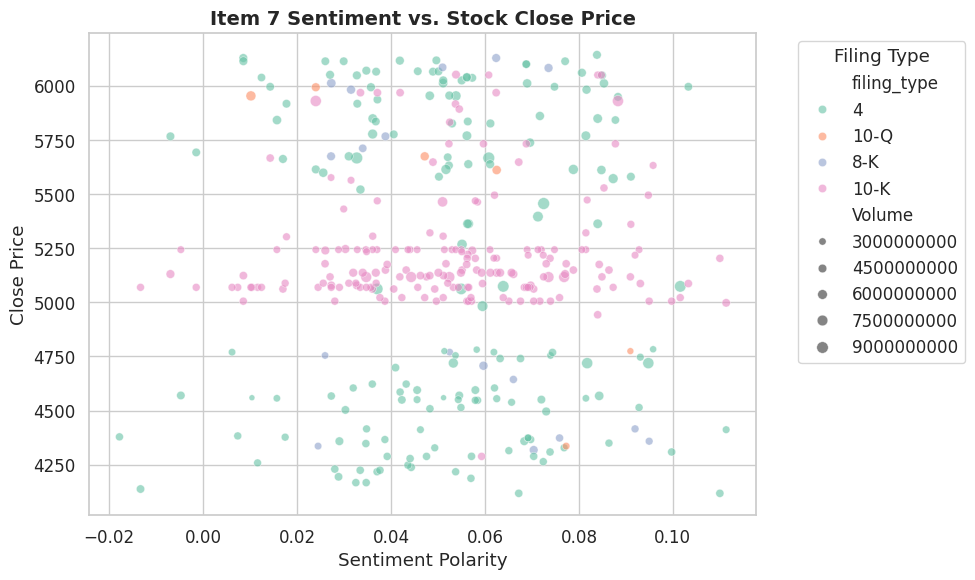

In [20]:
# Sentiment vs. stock price
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=imputed_df,
    x='item_7_sentiment',
    y='Close',
    hue='filing_type',
    size='Volume',
    palette='Set2',
    alpha=0.6
)
plt.title('Item 7 Sentiment vs. Stock Close Price', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Close Price')
plt.legend(title='Filing Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



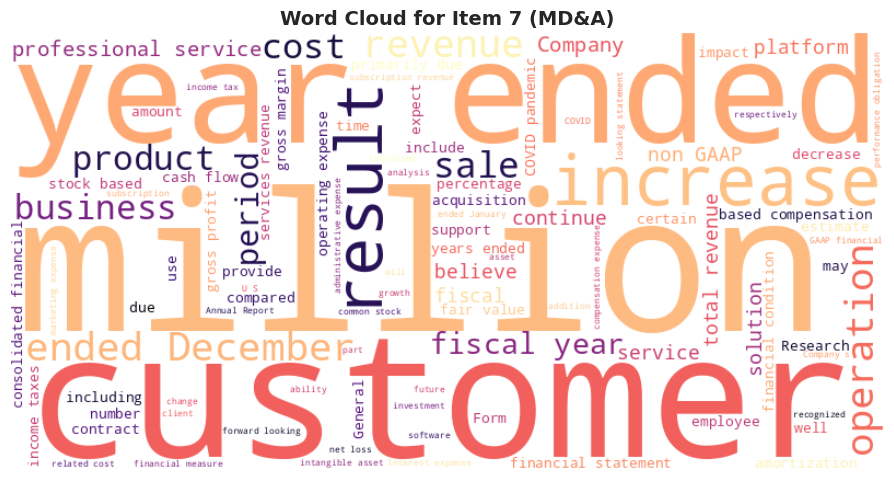

In [21]:
# Word cloud for item_7
text = ' '.join(imputed_df['item_7'].dropna().astype(str))
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='magma',
    max_words=100
).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Item 7 (MD&A)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# **NLP and Model Training with FineBERT**

In [29]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [25]:
# Agentic AI Reasoning: `item_7` contains financial insights. I’ll use FineBERT to extract sentiment, train a classifier to predict stock price movement (up/down), and visualize NLP results, linking text to stock performance.

import os
os.environ["WANDB_MODE"] = "disabled"  # Disable WandB

# Prepare target variable
imputed_df['next_close'] = imputed_df['Close'].shift(-1)
imputed_df['price_movement'] = (imputed_df['next_close'] > imputed_df['Close']).astype(int)

# Filter valid rows
model_df = imputed_df[imputed_df['item_7'].notnull() & imputed_df['price_movement'].notnull()].copy()
model_df['item_7'] = model_df['item_7'].fillna("No significant management discussion available.")
model_df = model_df[model_df['item_7'].str.len() > 50]

# Load FineBERT
model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,  # Binary classification
    hidden_dropout_prob=0.3,
    ignore_mismatched_sizes=True  # Fix: Allow classifier layer mismatch
).to(device)

# Tokenize function
def tokenize_text(text, max_length=512):
    return tokenizer(
        str(text),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

# Dataset class
class FinancialDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = tokenize_text(self.texts[idx])
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Prepare data
texts = model_df['item_7'].tolist()
labels = model_df['price_movement'].tolist()

# Split data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

# Create datasets
train_dataset = FinancialDataset(train_texts, train_labels)
val_dataset = FinancialDataset(val_texts, val_labels)

# Training arguments
training_args = TrainingArguments(
    output_dir='./finbert_results',
    num_train_epochs=10,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=20,
    learning_rate=2e-5,
    lr_scheduler_type="cosine",
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"  # Disable WandB
)

# Compute metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train model
trainer.train()

# Evaluate model
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

# Predict sentiment
def get_sentiment(text):
    inputs = tokenize_text(text)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=-1)
    return probs[:, 1].item()  # Probability of positive class

imputed_df['item_7_sentiment'] = imputed_df['item_7'].apply(get_sentiment)



config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-tone and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.513900,0.891718,0.753247,0.000000,0.000000,0.000000
2,0.597900,0.811409,0.753247,0.000000,0.000000,0.000000
3,0.561700,0.816629,0.753247,0.000000,0.000000,0.000000
4,0.328800,0.630667,0.753247,0.000000,0.000000,0.000000
5,0.433700,0.755665,0.753247,0.000000,0.000000,0.000000
6,0.599700,0.769466,0.753247,0.000000,0.000000,0.000000
7,0.631100,0.809687,0.753247,0.000000,0.000000,0.000000
8,0.405300,0.804001,0.753247,0.000000,0.000000,0.000000
9,0.501900,0.812707,0.753247,0.000000,0.000000,0.000000
10,0.861200,0.813957,0.753247,0.000000,0.000000,0.000000


Evaluation Results: {'eval_loss': 0.8917176723480225, 'eval_accuracy': 0.7532467532467533, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 2.3144, 'eval_samples_per_second': 33.27, 'eval_steps_per_second': 8.642, 'epoch': 10.0}


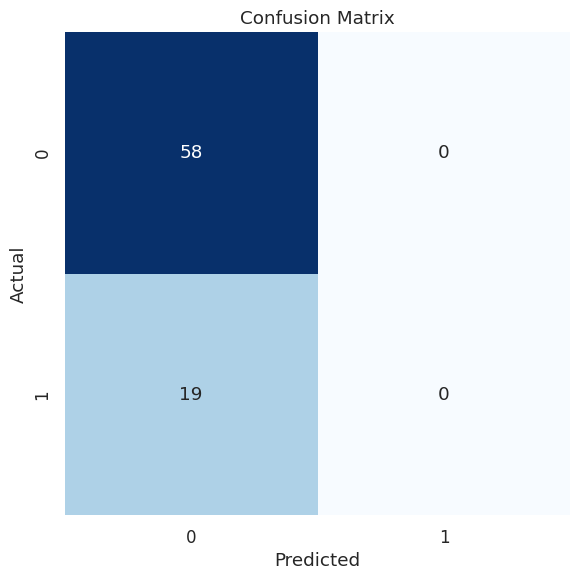

In [30]:
# Additional Evaluations
# 1. Confusion Matrix
val_predictions = trainer.predict(val_dataset)
val_preds = val_predictions.predictions.argmax(-1)
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

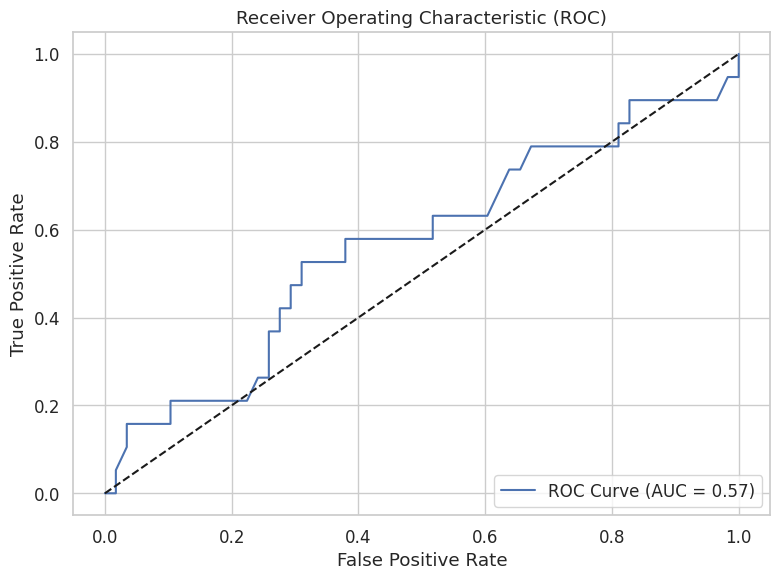

In [34]:
# 2. ROC Curve and AUC (Enhanced with colors and bold text)
val_probs = torch.softmax(torch.tensor(val_predictions.predictions), dim=-1)[:, 1].numpy()
fpr, tpr, _ = roc_curve(val_labels, val_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='royalblue', linewidth=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')  # Diagonal line

# Styling
plt.title('Receiver Operating Characteristic (ROC)', fontsize=16, fontweight='bold')
plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Legend
plt.legend(loc='lower right', fontsize=12)
plt.tight_layout()
plt.show()


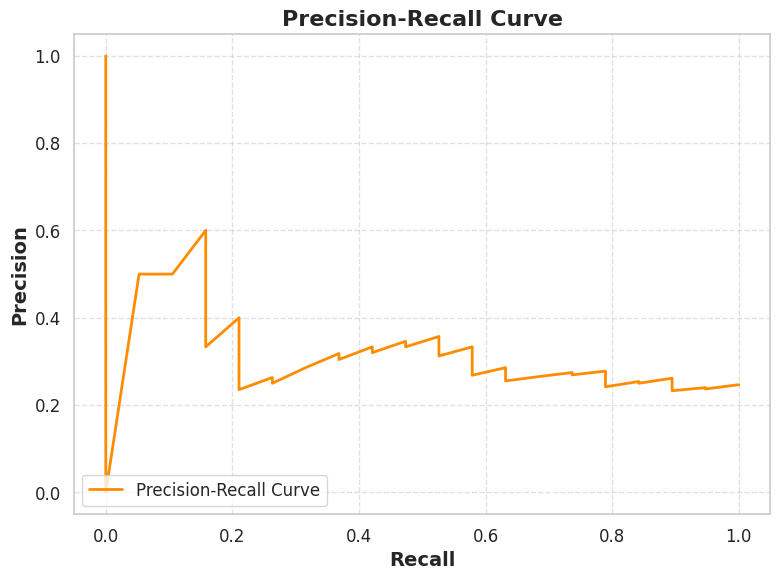

In [35]:
# 3. Precision-Recall Curve (Enhanced with colors and bold text)
precision, recall, _ = precision_recall_curve(val_labels, val_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', linewidth=2, label='Precision-Recall Curve')

# Styling
plt.title('Precision-Recall Curve', fontsize=16, fontweight='bold')
plt.xlabel('Recall', fontsize=14, fontweight='bold')
plt.ylabel('Precision', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Legend
plt.legend(loc='lower left', fontsize=12)
plt.tight_layout()
plt.show()


In [33]:
from sklearn.model_selection import KFold

# 4. Cross-Validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)
cv_scores = {'accuracy': [], 'f1': []}
for train_idx, val_idx in kf.split(texts):
    train_texts_k = [texts[i] for i in train_idx]
    val_texts_k = [texts[i] for i in val_idx]
    train_labels_k = [labels[i] for i in train_idx]
    val_labels_k = [labels[i] for i in val_idx]

    train_dataset_k = FinancialDataset(train_texts_k, train_labels_k)
    val_dataset_k = FinancialDataset(val_texts_k, val_labels_k)

    model_k = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2,
        hidden_dropout_prob=0.3,
        ignore_mismatched_sizes=True
    ).to(device)

    trainer_k = Trainer(
        model=model_k,
        args=training_args,
        train_dataset=train_dataset_k,
        eval_dataset=val_dataset_k,
        compute_metrics=compute_metrics
    )

    trainer_k.train()
    cv_results = trainer_k.evaluate()
    cv_scores['accuracy'].append(cv_results['eval_accuracy'])
    cv_scores['f1'].append(cv_results['eval_f1'])

print("Cross-Validation Results:")
print(f"Accuracy: {np.mean(cv_scores['accuracy']):.3f} ± {np.std(cv_scores['accuracy']):.3f}")
print(f"F1-Score: {np.mean(cv_scores['f1']):.3f} ± {np.std(cv_scores['f1']):.3f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-tone and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.680500,0.601979,0.753247,0.000000,0.000000,0.000000
2,0.616500,0.632770,0.753247,0.000000,0.000000,0.000000
3,0.817800,0.660260,0.753247,0.000000,0.000000,0.000000
4,0.749300,0.718097,0.753247,0.000000,0.000000,0.000000
5,0.509400,0.801553,0.753247,0.000000,0.000000,0.000000
6,0.815500,0.921579,0.753247,0.000000,0.000000,0.000000
7,0.603400,0.943538,0.753247,0.000000,0.000000,0.000000
8,0.202200,0.953919,0.753247,0.000000,0.000000,0.000000
9,0.467700,0.982507,0.753247,0.000000,0.000000,0.000000
10,0.610700,0.979500,0.753247,0.000000,0.000000,0.000000


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-tone and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.865400,0.446685,0.844156,0.000000,0.000000,0.000000
2,0.751500,0.442792,0.844156,0.000000,0.000000,0.000000
3,0.387500,0.506380,0.844156,0.000000,0.000000,0.000000
4,0.537500,0.448181,0.844156,0.000000,0.000000,0.000000
5,0.510700,0.456234,0.844156,0.000000,0.000000,0.000000
6,0.547500,0.455897,0.844156,0.000000,0.000000,0.000000
7,0.459700,0.466947,0.844156,0.000000,0.000000,0.000000
8,0.428100,0.475042,0.844156,0.000000,0.000000,0.000000
9,0.589300,0.488800,0.844156,0.000000,0.000000,0.000000
10,0.481300,0.492275,0.844156,0.000000,0.000000,0.000000


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-tone and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.427800,0.788297,0.776316,0.000000,0.000000,0.000000
2,0.761100,0.805555,0.776316,0.000000,0.000000,0.000000
3,0.873300,0.666452,0.776316,0.000000,0.000000,0.000000
4,0.705100,0.603729,0.776316,0.000000,0.000000,0.000000
5,0.561900,0.659121,0.776316,0.000000,0.000000,0.000000
6,0.372200,0.705554,0.776316,0.000000,0.000000,0.000000
7,0.450800,0.794294,0.776316,0.000000,0.000000,0.000000
8,0.451200,0.687976,0.776316,0.000000,0.000000,0.000000
9,0.543700,0.691485,0.776316,0.000000,0.000000,0.000000
10,0.503200,0.690765,0.776316,0.000000,0.000000,0.000000


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-tone and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.655400,0.603538,0.828947,0.000000,0.000000,0.000000
2,0.503400,0.573238,0.828947,0.000000,0.000000,0.000000
3,0.419700,0.715096,0.828947,0.000000,0.000000,0.000000
4,0.494900,0.580863,0.828947,0.000000,0.000000,0.000000
5,0.592800,0.474850,0.828947,0.000000,0.000000,0.000000
6,0.541900,0.465301,0.828947,0.000000,0.000000,0.000000
7,0.536300,0.478402,0.828947,0.000000,0.000000,0.000000
8,0.559200,0.510630,0.828947,0.000000,0.000000,0.000000
9,0.458600,0.528793,0.828947,0.000000,0.000000,0.000000
10,0.357300,0.539768,0.828947,0.000000,0.000000,0.000000


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-tone and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.501000,0.535450,0.828947,0.000000,0.000000,0.000000
2,0.718200,0.518496,0.828947,0.000000,0.000000,0.000000
3,0.650600,0.567065,0.828947,0.000000,0.000000,0.000000
4,0.775000,0.478711,0.828947,0.000000,0.000000,0.000000
5,0.545100,0.522794,0.828947,0.000000,0.000000,0.000000
6,0.937000,0.494015,0.828947,0.000000,0.000000,0.000000
7,0.569600,0.491989,0.828947,0.000000,0.000000,0.000000
8,0.470900,0.529973,0.828947,0.000000,0.000000,0.000000
9,0.388400,0.538959,0.815789,0.000000,0.000000,0.000000
10,0.654900,0.544451,0.815789,0.000000,0.000000,0.000000


Cross-Validation Results:
Accuracy: 0.806 ± 0.035
F1-Score: 0.000 ± 0.000


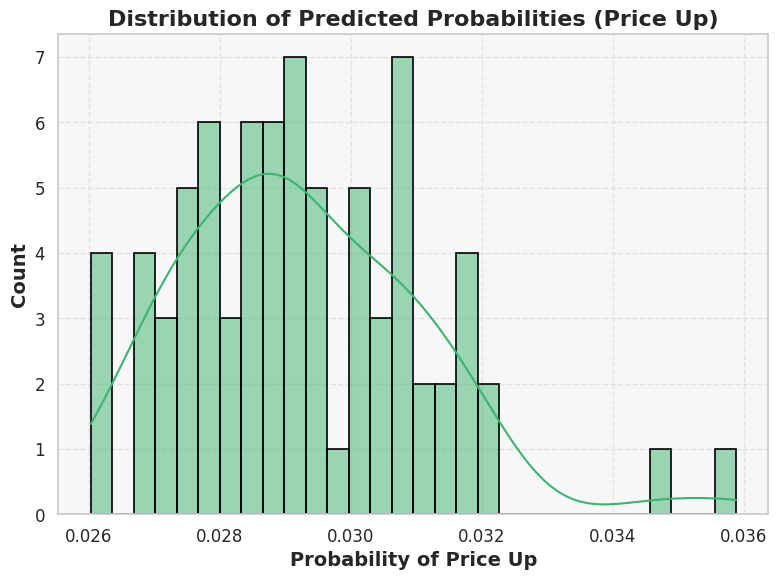

In [38]:
# 5. Prediction Distribution (Enhanced with colors)
plt.figure(figsize=(8, 6))

# Use a colorful palette (e.g., coolwarm or cubehelix for gradients)
sns.histplot(val_probs, bins=30, kde=True, color='mediumseagreen', edgecolor='black', linewidth=1.2)

# Styling
plt.title('Distribution of Predicted Probabilities (Price Up)', fontsize=16, fontweight='bold')
plt.xlabel('Probability of Price Up', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Background and axis color tweak (optional)
plt.gca().set_facecolor('#f7f7f7')  # light gray background
plt.tight_layout()
plt.show()


In [40]:
from termcolor import colored

# 6. Error Analysis with colors and stock direction labels
val_df = pd.DataFrame({
    'text': val_texts,
    'true_label': val_labels,
    'pred_label': val_preds,
    'prob_up': val_probs
})
errors = val_df[val_df['true_label'] != val_df['pred_label']].head(5)

print(colored("\n🔍 Error Analysis (Top 5 Misclassified Examples):", 'cyan', attrs=['bold']))

for idx, row in errors.iterrows():
    true_str = "📈 Stock Up" if row['true_label'] == 1 else "📉 Stock Down"
    pred_str = "📈 Stock Up" if row['pred_label'] == 1 else "📉 Stock Down"

    print(colored("\n📄 Text (truncated):", 'magenta', attrs=['bold']), colored(f"{row['text'][:200]}...", 'white'))
    print(colored("✔️ True Label:", 'green'), colored(f"{true_str} ({row['true_label']})", 'green', attrs=['bold']))
    print(colored("❌ Predicted Label:", 'red'), colored(f"{pred_str} ({row['pred_label']})", 'red', attrs=['bold']))
    print(colored("📊 Probability (Price Up):", 'blue'), colored(f"{row['prob_up']:.3f}", 'blue', attrs=['bold']))



🔍 Error Analysis (Top 5 Misclassified Examples):

📄 Text (truncated): ITEM 7. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCIAL CONDITION AND RESULTS OF OPERATIONS
The following discussion and analysis of our financial condition and results of operations should be read ...
✔️ True Label: 📈 Stock Up (1)
❌ Predicted Label: 📉 Stock Down (0)
📊 Probability (Price Up): 0.027

📄 Text (truncated): Item 7. Management’s Discussion and Analysis of Financial Condition and Results of Operations
The following discussion and analysis summarizes the significant factors affecting the consolidated operat...
✔️ True Label: 📈 Stock Up (1)
❌ Predicted Label: 📉 Stock Down (0)
📊 Probability (Price Up): 0.026

📄 Text (truncated): ITEM 7. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCIAL CONDITION AND RESULTS OF OPERATIONS
RESULTS OF OPERATIONS
The following table sets forth, for the years indicated, certain line items from our...
✔️ True Label: 📈 Stock Up (1)
❌ Predicted Label: 📉 Stock Down (0)
📊 Probability